In [166]:
import matlab
import matlab.engine
import numpy as np
import os
from itertools import permutations, product
import random

In [167]:
eng = matlab.engine.start_matlab() 
eng.addpath('.', nargout=0) 
### See http://cvxr.com/cvx/ and https://docs.mosek.com/latest/toolbox/install-interface.html for more information on installation.
### The subdirectory w64 (Windows)/ maci64 (Mac) in cvx can be found in cvx/mosek.
eng.addpath(r'w64',nargout=0)

In [168]:
import math
import random
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import operator
import gudhi as gd
from sklearn.cluster import KMeans

def Extract0(lst): 
    return [item[0] for item in lst]  ### extract the first element in the sublist
def Extract1(lst): 
    return [item[1] for item in lst]  ### extract the second element in the sublist
def Extract2(lst): 
    return [item[2] for item in lst]  ### extract the second element in the sublist

def rips_filtration(data, max_edge):

    birth1_all = []
    death1_all = []

    for i in range(len(data)):
        rips_complex = gd.RipsComplex(points=data[i],
                                     max_edge_length=max_edge)

        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

        BarCodes_Rips01 = simplex_tree.persistence()
        index = Extract0(BarCodes_Rips01).index(0) ### remove the infinity bar
        del BarCodes_Rips01[index]
    
        index = Extract0(BarCodes_Rips01).index(0) ### seperate H0 and H1
        BarCodes_Rips1 = Extract1(BarCodes_Rips01[0:index]) ### remmoving the dimension number
    
        birth1 = []
        death1 = []
        for item in BarCodes_Rips1: ### extracting birth and death for H1
            birth1.append(item[0])
            death1.append(item[1])
        birth1_all.append(birth1)
        death1_all.append(death1)
    return (birth1_all, death1_all)   

def bar_length(data, birth1_all, death1_all): ### death1_all, birth1_all are the output from filtration
    bar_length_h1 = []

    for i in range(len(data)):
        bar_length = np.subtract(death1_all[i],birth1_all[i])
        bar_length_h1.append(bar_length)
        
    return(bar_length_h1)

In [169]:
def s(theta, t):
    x = theta[0] + theta[2] * np.cos(t)
    y = theta[1] + theta[2] * np.sin(t)
    return np.array([x, y])

x_pre_change = []
y_pre_change = []
pre_change = []
width = 2.8
height = 1.4
for i in range(20):
    ts = np.linspace(0, 2 * np.pi, num=100) ### 100 points sampled on circle
    cx = 0; cy = 0; r = 1; noise = 0.05 ### set the noise to be 0.05
    ss = s([cx, cy, r], ts)
    ss[0] += noise * np.random.randn(ts.shape[0]) ### uniform distribution over [0, 1)
    ss[1] += noise * np.random.randn(ts.shape[0])
    ss[0] = ss[0] * width/2.0
    ss[1] = ss[1] * height/2.0
    x_pre_change.append(ss[0])
    y_pre_change.append(ss[1])
    pre_change.append(list(zip(ss[0], ss[1])))
    
x_post_change = []
y_post_change = []
post_change = []
width = 2.8
height = 1.4
for i in range(20):
    ts = np.linspace(0, 2 * np.pi, num=100) ### 100 points sampled on circle
    cx = 0; cy = 0; r = 1; noise = 0.10 ### set the noise to be 0.05
    ss = s([cx, cy, r], ts)
    ss[0] += noise * np.random.randn(ts.shape[0]) ### uniform distribution over [0, 1)
    ss[1] += noise * np.random.randn(ts.shape[0])
    ss[0] = ss[0] * width/2.0
    ss[1] = ss[1] * height/2.0
    x_post_change.append(ss[0])
    y_post_change.append(ss[1])
    post_change.append(list(zip(ss[0], ss[1])))
    
data = pre_change+ post_change
data = np.array(data)

In [170]:
birth1_all_pre, death1_all_pre = rips_filtration(pre_change, 5)
bar_length_h1_pre = bar_length(pre_change, birth1_all_pre, death1_all_pre)

birth1_all_post, death1_all_post = rips_filtration(post_change, 5)
bar_length_h1_post = bar_length(post_change, birth1_all_post, death1_all_post)

In [171]:
birth1_all_pre_flat = sum(birth1_all_pre, [])
bar_length_h1_pre = [l.tolist() for l in bar_length_h1_pre]
bar_length_h1_pre_flat = sum(bar_length_h1_pre, [])
pre_flat = zip(birth1_all_pre_flat, bar_length_h1_pre_flat)
sorted_pre_flat = sorted(pre_flat)

birth1_all_post_flat = sum(birth1_all_post, [])
bar_length_h1_post = [l.tolist() for l in bar_length_h1_post]
bar_length_h1_post_flat = sum(bar_length_h1_post, [])
post_flat = zip(birth1_all_post_flat, bar_length_h1_post_flat)
sorted_post_flat = sorted(post_flat)

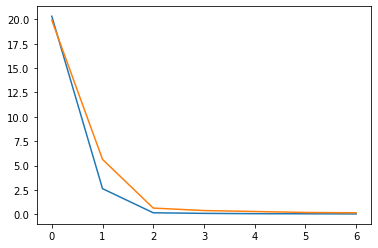

In [172]:
# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i][0] - curr_center[0]) ** 2 + (points[i][1] - curr_center[1]) ** 2
    sse.append(curr_sse)
  return sse

plt.plot(calculate_WSS(sorted_pre_flat, 7)) ### 2 clusters
plt.plot(calculate_WSS(sorted_post_flat, 7)) ### 2 clusters

[[0.25529084 1.08818905]
 [0.31119273 0.92205426]
 [0.23619563 0.01965223]
 [0.17702578 0.01349417]]


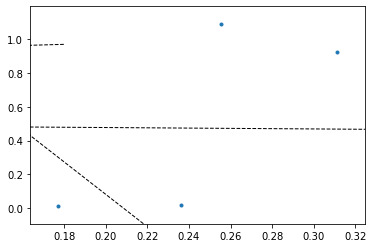

In [173]:
kmeans_pre = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_pre.fit(sorted_pre_flat)
kmeans_post = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_post.fit(sorted_post_flat)

centroid_pre = np.append(kmeans_pre.cluster_centers_,np.zeros([len(kmeans_pre.cluster_centers_),1]),1)
centroid_post = np.append(kmeans_post.cluster_centers_,np.ones([len(kmeans_post.cluster_centers_),1]),1)
centroid_both = np.concatenate((centroid_pre, centroid_post), axis=0)
centroid_both = centroid_both[np.argsort(-centroid_both[:, 1])]

centroid_both_vor = centroid_both[:,0:2]
print(centroid_both_vor)

from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(centroid_both_vor)

fig = voronoi_plot_2d(vor)
plt.show()

In [176]:
zip_all_pre = []
for i in range(len(pre_change)):
    #bar_length_h1_pre[i] = [l.tolist() for l in bar_length_h1_pre[i]]
    zip_all_pre.append(tuple(zip(birth1_all_pre[i], bar_length_h1_pre[i])))

zip_all_post = []
for i in range(len(post_change)):
    #bar_length_h1_post[i] = [l.tolist() for l in bar_length_h1_post[i]]
    zip_all_post.append(tuple(zip(birth1_all_post[i], bar_length_h1_post[i])))

points = np.array([[0.25529084, 1.08818905],
 [0.31119273, 0.92205426],
 [0.23619563, 0.01965223],
 [0.17702578, 0.01349417]])

prop_all_pre = []
for i in range(len(zip_all_pre)):
    point_index = []
    for j in range(len(zip_all_pre[i])):
        point_index.append(np.argmin(np.sum((points - list(zip_all_pre[i][j]))**2, axis=1)))
    prop = []
    for i in range(len(points)):
        prop.append(point_index.count(i))
    prop_all_pre.append(prop)

prop_all_post = []
for i in range(len(zip_all_post)):
    point_index = []
    for j in range(len(zip_all_post[i])):
        point_index.append(np.argmin(np.sum((points - list(zip_all_post[i][j]))**2, axis=1)))
    prop = []
    for i in range(len(points)):
        prop.append(point_index.count(i))
    prop_all_post.append(prop)

prop_all_pre/=np.sum(prop_all_pre, axis=1).reshape(-1,1)
prop_all_post/=np.sum(prop_all_post, axis=1).reshape(-1,1)
hist_pre = prop_all_pre
hist_post = prop_all_post

In [177]:
hist_pre_permute = []
hist_post_permute = []
for i in range(1000):
    hist_pre_permute.append(random.sample(hist_pre.tolist(), 20))
    hist_post_permute.append(random.sample(hist_post.tolist(), 20))

pre_post_avg = []
pre_post_pair = list(product(hist_pre, hist_post))
for i in range(400):
    pre_post_avg.append((np.array(pre_post_pair[i][0])+ np.array(pre_post_pair[i][1]))/2)
pre_post_avg = np.array(pre_post_avg).T.tolist()
pre_post_avg = matlab.double(pre_post_avg)  

weights_opt = eng.optimal_weights_tda(pre_post_avg) 
#weights_opt = eng.optimal_weights_tda(hist_pre, hist_post) 
weights_opt = np.asarray(weights_opt).tolist()
weights_opt = [ item for elem in weights_opt for item in elem]
weights_opt

[2.304165546247164, 2.0447645436778212, 2.1681953600925272, 1.702700233400409]